Getting started with Task 3
Download the dataset from the Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals using the script download_intracardiac_dataset.sh:

source download_intracardiac_dataset.sh
Load Modules and Preprocessing Functions
Load modules and preprocessing functions.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
# setting data folder
data_folder = './yourpath/'

Mounted at /content/drive/


In [ ]:
ls drive/MyDrive/data_task3/

data_hearts_dd_0p2/                      data_hearts_dd_0p2_geo_inn_act_1_bcl/
data_hearts_dd_0p2_geo_act_1_bcl/        data_hearts_dd_0p2_geo_inn_act_1_bcl_I/
data_hearts_dd_0p2_geo_act_1_bcl_gkr/    data_hearts_dd_0p2_geo_inn_act_2_bcl/
data_hearts_dd_0p2_geo_act_1_bcl_gkr_I/  data_hearts_dd_0p2_geo_inn_act_2_bcl_I/
data_hearts_dd_0p2_geo_act_2_bcl/        data_hearts_dd_0p2_geo_inn_act_3_bcl/
data_hearts_dd_0p2_geo_act_2_bcl_gkr/    data_hearts_dd_0p2_geo_inn_act_3_bcl_I/
data_hearts_dd_0p2_geo_act_2_bcl_gkr_I/  documentation/
data_hearts_dd_0p2_geo_act_3_bcl/        figures/
data_hearts_dd_0p2_geo_act_3_bcl_gkr/    intracardiac_dataset/
data_hearts_dd_0p2_geo_act_3_bcl_gkr_I/  license/
data_hearts_dd_0p2_geo_inn/              notebooks/


In [ ]:
import glob, re, os
import numpy as np
import matplotlib.pyplot as plt
from typing import List

In [ ]:
def read_data_dirs(
        dirs_names : List[str] = ['../intracardiac_dataset/data_hearts_dd_0p2/'],
        verbose : int = 0) -> List[List[str]]:
    """
    Read the numpy files in the given directories.
    Returns a list of file pairs ECG/Vm.

    Parameters
    ----------
    dirs_names : List[str]
        List of directories containing the data.
    verbose : int
        Verbosity level.

    Returns
    -------
    file_pairs : List[List[str]]
        List of file pairs.
    """
    file_pairs = []

    for dir in dirs_names:
        all_files = sorted(glob.glob(dir + '/*.npy'))
        files_Vm=[]
        files_pECG=[]

        if verbose > 0:
            print('Reading files...',end='')
        for file in all_files:
            if 'VmData' in file:
                files_Vm.append(file)
            if 'pECGData' in file:
                files_pECG.append(file)
        if verbose > 0:
            print(' done.')

        if verbose > 0:
            print('len(files_pECG) : {}'.format(len(files_pECG)))
            print('len(files_Vm) : {}'.format(len(files_Vm)))

        for i in range(len(files_pECG)):
            VmName =  files_Vm[i]
            VmName = VmName.replace('VmData', '')
            pECGName =  files_pECG[i]
            pECGName = pECGName.replace('pECGData', '')
            if pECGName == VmName :
                file_pairs.append([files_pECG[i], files_Vm[i]])
            else:
                print('Automatic sorted not matching, looking for pairs ...',end='')
                for j in range(len(files_Vm)):
                    VmName =  files_Vm[j]
                    VmName = VmName.replace('VmData', '')
                    if pECGName == VmName :
                        file_pairs.append([files_pECG[i], files_Vm[j]])
                print('done.')
    return file_pairs

In [ ]:
def get_standard_leads(
        pECGnumpy : np.ndarray
    ) -> np.ndarray :
    """
    Get the standard 12-lead from the 10-lead ECG.

    Parameters
    ----------
    pECGnumpy : np.ndarray
        10-lead ECG.

    Returns
    -------
    ecg12aux : np.ndarray
        12-lead ECG.
    """
    # pECGnumpy  : RA LA LL RL V1 V2 V3 V4 V5 V6
    # ecg12aux : i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5, v6
    ecg12aux = np.zeros((pECGnumpy.shape[0],12))
    WilsonLead = 0.33333333 * (pECGnumpy[:,0] + pECGnumpy[:,1] + pECGnumpy[:,2])
    # Lead I: LA - RA
    ecg12aux[:,0] = pECGnumpy[:,1] - pECGnumpy[:,0]
    # Lead II: LL - RA
    ecg12aux[:,1] = pECGnumpy[:,2] - pECGnumpy[:,0]
    # Lead III: LL - LA
    ecg12aux[:,2] = pECGnumpy[:,2] - pECGnumpy[:,1]
    # Lead aVR: 3/2 (RA - Vw)
    ecg12aux[:,3] = 1.5*(pECGnumpy[:,0] - WilsonLead)
    # Lead aVL: 3/2 (LA - Vw)
    ecg12aux[:,4] = 1.5*(pECGnumpy[:,1] - WilsonLead)
    # Lead aVF: 3/2 (LL - Vw)
    ecg12aux[:,5] = 1.5*(pECGnumpy[:,2] - WilsonLead)
    # Lead V1: V1 - Vw
    ecg12aux[:,6] = pECGnumpy[:,4] - WilsonLead
    # Lead V2: V2 - Vw
    ecg12aux[:,7] = pECGnumpy[:,5] - WilsonLead
    # Lead V3: V3 - Vw
    ecg12aux[:,8] = pECGnumpy[:,6] - WilsonLead
    # Lead V4: V4 - Vw
    ecg12aux[:,9] = pECGnumpy[:,7] - WilsonLead
    # Lead V5: V5 - Vw
    ecg12aux[:,10] = pECGnumpy[:,8] - WilsonLead
    # Lead V6: V6 - Vw
    ecg12aux[:,11] = pECGnumpy[:,9] - WilsonLead

    return ecg12aux

In [ ]:
def get_activation_time(
        Vm : np.ndarray
    ) -> np.ndarray :
    """
    Get the activation time from the Vm.

    Parameters
    ----------
    Vm : np.ndarray
        Vm.

    Returns
    -------
    actTime : np.ndarray
        Activation time.
    """
    actTime = []
    # check that Vm has 75 columns
    if Vm.shape[1] != 75:
        print('Error: Vm does not have 75 columns')
        return actTime
    for col in range(0,75,1):
        actTime.append(np.argmax(Vm[:,col]>0))
    actTime = np.asarray(actTime)
    actTime = np.reshape(actTime,(75,1))
    return actTime

In [ ]:
#%run cardiac_ml_tools.py

In [ ]:
data_dirs = []
regex = r'data_hearts_dd_0p2*'
DIR='drive/MyDrive/data_task3/' # This should be the path to the intracardiac_dataset, it can be downloaded using data_science_challenge_2023/download_intracardiac_dataset.sh
for x in os.listdir(DIR):
    if re.match(regex, x):
        data_dirs.append(DIR + x)
file_pairs = read_data_dirs(data_dirs)
print('Number of file pairs: {}'.format(len(file_pairs)))
# example of file pair
print("Example of file pair:")
print("{}\n{}".format(file_pairs[0][0], file_pairs[0][1]))

In [ ]:
# Example of file pair
case = 213
# ECG plot
row = 3
column = 4
num_timesteps = 500
plt.figure(figsize=(10, 7))
titles = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
reorder = {1:1,2:5,3:9,4:2,5:6,6:10,7:3,8:7,9:11,10:4,11:8,12:12} # reorder the leads to standard 12-lead ECG display

print('Case {} : {}'.format(case, file_pairs[case][0]))
pECGData = np.load(file_pairs[case][0])
pECGData = get_standard_leads(pECGData)

# create a figure with 12 subplots
for i in range(pECGData.shape[1]):
    plt.subplot(row, column, reorder[i + 1])
    plt.plot(pECGData[0:num_timesteps,i],'r')
    plt.title(titles[i])
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    plt.xlabel('msec')
    plt.ylabel('mV')
plt.tight_layout()
plt.show()
# close
plt.close()

In [ ]:
#ActTime.shape

In [ ]:
# Example of file pair
case = 213
plt.figure(figsize=(1, 10))

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])

ActTime = get_activation_time(VmData)

# plot the Activation Time array
plt.imshow(ActTime, cmap='jet', interpolation='nearest', aspect='auto')
plt.title('Activation Time')
plt.colorbar()
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
# not xticks
plt.xticks([])
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()

In [ ]:
# make a plot with the "pECGData" -> "ActTime"
case = 213

print('Case {} : {}'.format(case, file_pairs[case][0]))
pECGData = np.load(file_pairs[case][0])
pECGData = get_standard_leads(pECGData)

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])
ActTime = get_activation_time(VmData)

# plot in row the tensors pECGData and ActTime with an arrow pointing to the activation time
row = 1
column = 3
plt.figure(figsize=(20, 5))
plt.subplot(row, column, 1)
# plot pECGData transposed
plt.imshow(pECGData.T, cmap='jet', interpolation='nearest', aspect='auto')
plt.title('pECGData')
plt.subplot(row, column, 2)
# print an arrow
plt.text(0.5, 0.5, '-------->', horizontalalignment='center', verticalalignment='center', fontsize=20)
plt.axis('off')
plt.subplot(row, column, 3)
# plot ActTime
plt.imshow(ActTime, cmap='jet', interpolation='nearest', aspect='auto')
# not xticks
plt.xticks([])
plt.title('ActTime')
plt.show()
plt.close()

In [ ]:
# Example of file pair
case = 213
# Vm plot
row = 7
column = 10
plt.figure(figsize=(18, 9))

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])

for count, i in enumerate(range(VmData.shape[1])):
    plt.subplot(8, 10, count + 1)
    plt.plot(VmData[0:num_timesteps,i])
    plt.title(f'i = {i}')
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    # plt.xlabel('msec')
    # plt.ylabel('mV')
plt.tight_layout()
plt.show()
# close
plt.close()

In [ ]:
import numpy as np

# Initialize an empty list to hold the concatenated results
# result = np.empty((100, 500, 12))  # Replace (0, 12) with the expected shape of pECGData
result = []

for i in range(16115):  # This will iterate from 0 to 99
    pECGData = np.load(file_pairs[i][0])  # Load your data
    pECGData = get_standard_leads(pECGData)  # Transform your data

    # # Concatenate the new pECGData to the result
    # result = np.concatenate((result, pECGData), axis=0)  # Concatenate along the first axis
    result.append(pECGData)

# Convert the list to a NumPy array
result = np.array(result)
print(result.shape)

In [ ]:
ls drive/MyDrive/LLNL_Team_Skaai

In [ ]:
# Save the array to Google Drive
np.save('/content/drive/MyDrive/LLNL_Team_Skaai/my_array.npy', result)

In [ ]:
output = []
for i in range(16115):
  VmData = np.load(file_pairs[i][1])
  ActTime = get_activation_time(VmData)
  #output = np.concatenate((output, ActTime), axis=0)
  output.append(ActTime)

output = np.array(output)
print(output.shape)

In [ ]:
np.save('/content/drive/MyDrive/LLNL_Team_Skaai/output.npy', output)

In [ ]:
x = np.load('/content/drive/MyDrive/LLNL_Team_Skaai/my_array.npy')

In [ ]:
y = np.load('/content/drive/MyDrive/LLNL_Team_Skaai/output.npy')

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [ ]:
import tensorflow.keras.backend as K
@keras.saving.register_keras_serializable()
def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/(SS_tot + K.epsilon())

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, AveragePooling1D

In [ ]:
import tensorflow as tf
from keras import layers

@tf.keras.utils.register_keras_serializable()
class FireLayer(tf.keras.layers.Layer):
    def __init__(self, squeeze_filters, expand_filters, **kwargs):
        super(FireLayer, self).__init__(**kwargs)
        self.squeeze = layers.Conv1D(squeeze_filters, 1, activation='relu', padding='valid')
        self.expand1x1 = layers.Conv1D(expand_filters, 1, activation='relu', padding='valid')
        self.expand3x3 = layers.Conv1D(expand_filters, 3, activation='relu', padding='same')

    def call(self, inputs):
        x = self.squeeze(inputs)
        output = tf.concat([self.expand1x1(x), self.expand3x3(x)], axis=-1)
        return output


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Flatten, Dense
from keras.layers import Reshape


model = Sequential()

# Initial Conv1D layer
model.add(Conv1D(64, 3, activation='relu', strides=1, padding='same', input_shape=(500, 12)))

# Fire layers
model.add(FireLayer(16, 64))

model.add(FireLayer(32, 128))

model.add(FireLayer(48, 192))

model.add(FireLayer(64, 256))

# Dropout layer
model.add(Dropout(0.1))

# Final Conv1D layer to reduce to a single feature output
# This layer needs to reduce the output to a shape compatible with (75, 1)
model.add(Conv1D(1, 3, activation='linear', padding='valid'))  # Produces shape (batch_size, 498, 1)

# Flatten the output to reduce the dimension and allow for Dense layers
model.add(Flatten())

# Fully connected layer to map to the desired output shape
model.add(Dense(75))  # Now output shape will be (batch_size, 75)

# Reshape to the final output shape (75, 1)
model.add(Reshape((75, 1)))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r_squared])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_52 (Conv1D)          (None, 500, 64)           2368      
                                                                 
 fire_layer_8 (FireLayer)    (None, 500, 128)          5264      
                                                                 
 fire_layer_9 (FireLayer)    (None, 500, 256)          20768     
                                                                 
 fire_layer_10 (FireLayer)   (None, 500, 384)          49584     
                                                                 
 fire_layer_11 (FireLayer)   (None, 500, 512)          90688     
                                                                 
 dropout_2 (Dropout)         (None, 500, 512)          0         
                                                                 
 conv1d_65 (Conv1D)          (None, 498, 1)           

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=64, verbose=1)

Epoch 1/10
162/162 [==============================] - 247s 2s/step - loss: 288.2093 - r_squared: 0.7586 - val_loss: 292.5450 - val_r_squared: 0.7578
Epoch 2/10
162/162 [==============================] - 241s 1s/step - loss: 284.4457 - r_squared: 0.7614 - val_loss: 296.8300 - val_r_squared: 0.7543
Epoch 3/10
162/162 [==============================] - 242s 1s/step - loss: 283.2449 - r_squared: 0.7618 - val_loss: 312.2369 - val_r_squared: 0.7414
Epoch 4/10
162/162 [==============================] - 247s 2s/step - loss: 281.0381 - r_squared: 0.7640 - val_loss: 283.4938 - val_r_squared: 0.7653
Epoch 5/10
162/162 [==============================] - 245s 2s/step - loss: 278.6405 - r_squared: 0.7655 - val_loss: 285.9075 - val_r_squared: 0.7632
Epoch 6/10
162/162 [==============================] - 246s 2s/step - loss: 278.0798 - r_squared: 0.7664 - val_loss: 282.2151 - val_r_squared: 0.7663
Epoch 7/10
162/162 [==============================] - 244s 2s/step - loss: 276.2099 - r_squared: 0.7677 - 

In [ ]:
y_predv1 = model_supreme.predict(X_test)

101/101 [==============================] - 21s 207ms/step


In [ ]:
y_predv2 = model.predict(X_test)

101/101 [==============================] - 20s 187ms/step


In [ ]:
model.save('/content/drive/MyDrive/LLNL_Team_Skaai/modelprelunch31.keras')

In [ ]:
model_supreme = tf.keras.models.load_model('/content/drive/MyDrive/LLNL_Team_Skaai/model.keras', custom_objects={"FireLayer": FireLayer, "r_squared": r_squared})

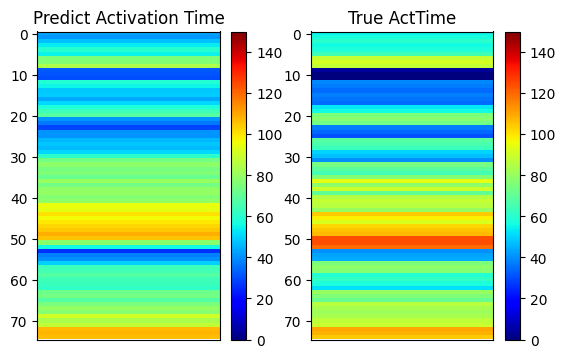

In [ ]:
ActTime_pred = y_pred[52]
ActTime_test = y_test[52]

row = 1
column = 3
plt.figure(figsize=(10, 4))

plt.subplot(row, column, 1)
plt.imshow(ActTime_pred, cmap='jet', interpolation='nearest', aspect='auto', vmin=0, vmax=150)
plt.title('Predict Activation Time')
plt.xticks([])
plt.colorbar()

plt.subplot(row, column, 2)
plt.imshow(ActTime_test, cmap='jet', interpolation='nearest', aspect='auto', vmin=0, vmax=150)
plt.title('True ActTime')
plt.xticks([])
plt.colorbar()
plt.show()
plt.close()

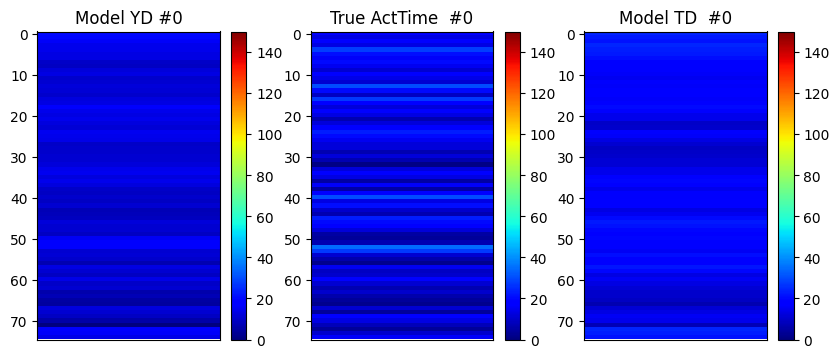

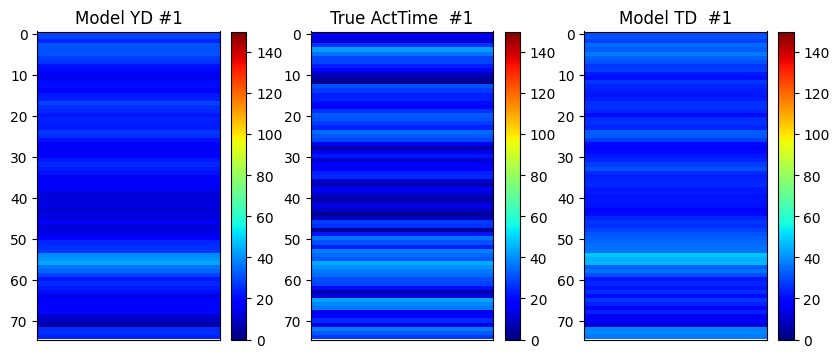

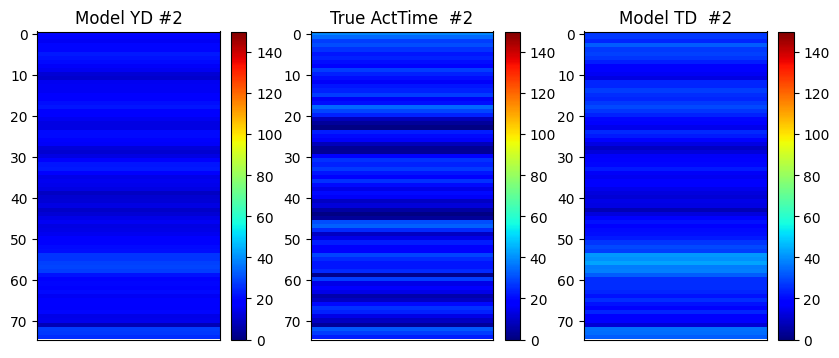

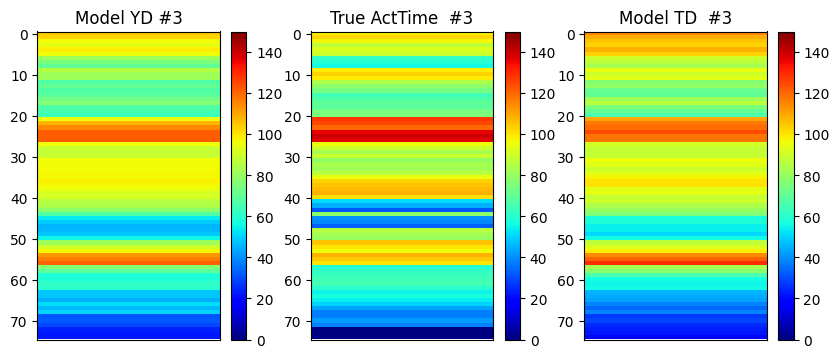

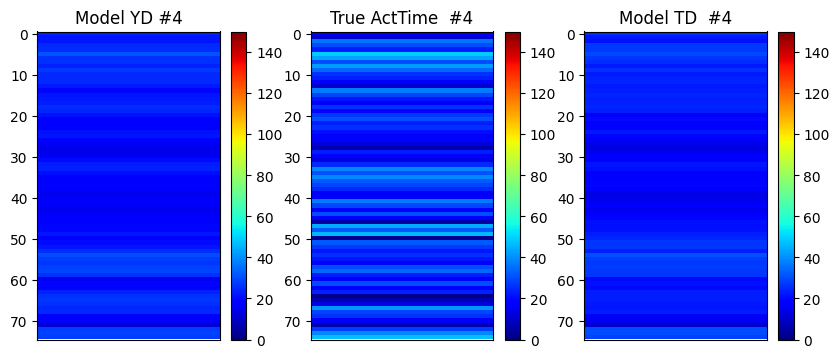

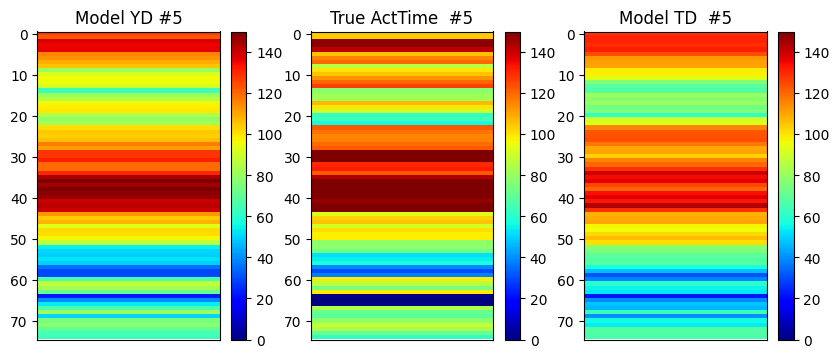

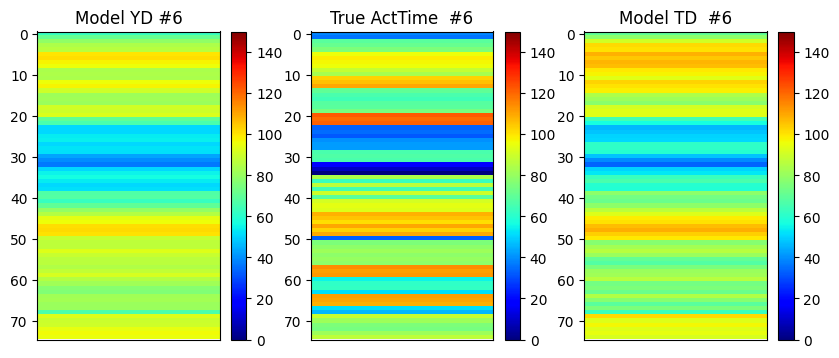

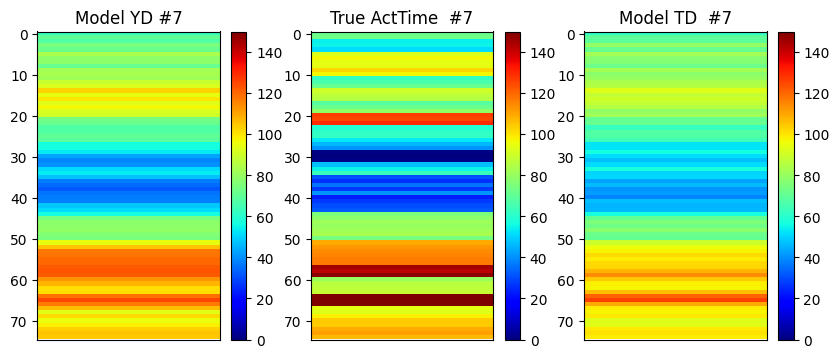

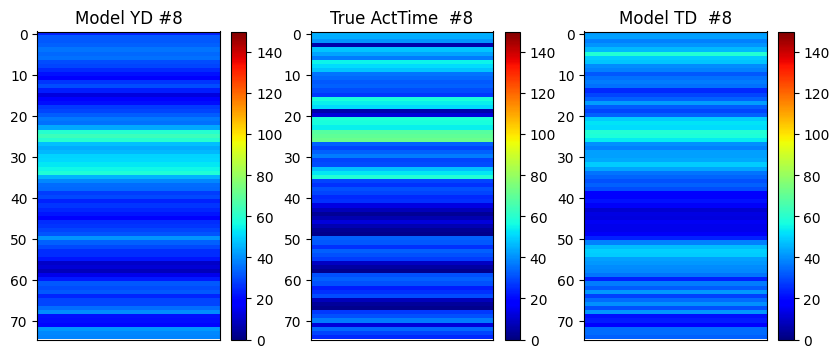

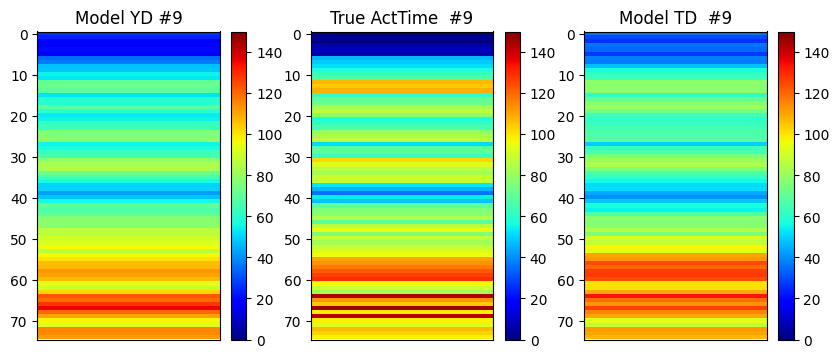

In [ ]:
for i in range(10):
  ActTime_test = y_test[i]
  ActTime_predv2 = y_predv2[i]
  ActTime_predv1 = y_predv1[i]

  row = 1
  column = 3
  plt.figure(figsize=(10, 4))

  plt.subplot(row, column, 1)
  plt.imshow(ActTime_predv1, cmap='jet', interpolation='nearest', aspect='auto', vmin=0, vmax=150)
  plt.title('Model YD #{}'.format(i))
  plt.xticks([])
  plt.colorbar()

  plt.subplot(row, column, 2)
  plt.imshow(ActTime_test, cmap='jet', interpolation='nearest', aspect='auto', vmin=0, vmax=150)
  plt.title('True ActTime  #{}'.format(i))
  plt.xticks([])
  plt.colorbar()

  plt.subplot(row, column, 3)
  plt.imshow(ActTime_predv2, cmap='jet', interpolation='nearest', aspect='auto', vmin=0, vmax=150)
  plt.title('Model TD  #{}'.format(i))
  plt.xticks([])
  plt.colorbar()

  plt.show()
  plt.close()

In [ ]:
mae = np.mean(np.abs(y_test - y_pred))
print("Mean Absolute Error:", mae)

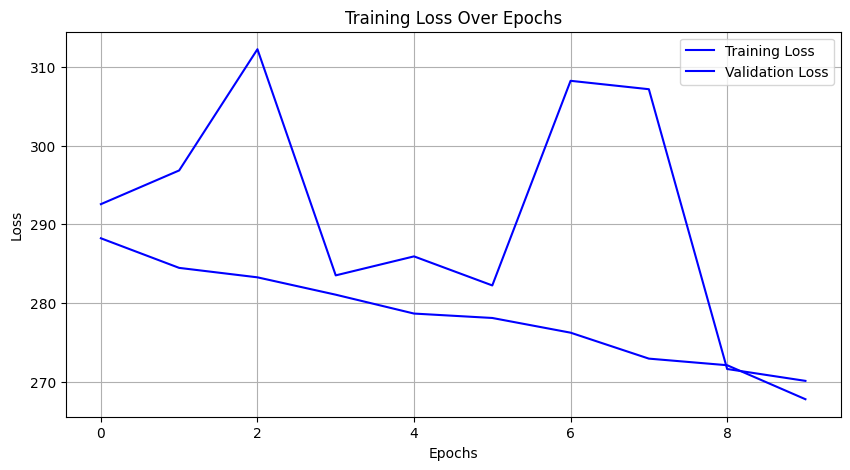

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()